<a href="https://colab.research.google.com/github/ddopazo92/Introduccion_datascience_diego_dopazo/blob/main/Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Predictivo para Ventas de Videojuegos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Cargar y preparar datos (reutilizando código del notebook original)
url = 'https://raw.githubusercontent.com/ddopazo92/Introduccion_datascience_diego_dopazo/refs/heads/main/Video_Games.csv'
df = pd.read_csv(url, sep=';')

# Renombrar columnas al español
df = df.set_axis(['Juego', 'Consola', 'Año de lanzamiento','Genero', 'Publicador', 'Ventas USA',
                  'Ventas Europa', 'Ventas Japon','Ventas resto del Mundo', 'Ventas Totales',
                  'Puntuacion de criticos','Cantidad de criticos', 'Puntaje de Usuario',
                  'Cantidad de usuarios','Desarrollador','Clasificacion por Edad'], axis=1)

# Limpieza y transformaciones
df['Juego'] = df['Juego'].str.upper()
df['Genero'] = df['Genero'].str.replace('Action','Accion')
df['Genero'] = df['Genero'].str.replace('Adventure','Aventura')
df['Genero'] = df['Genero'].str.replace('Fighting','Lucha')
df['Genero'] = df['Genero'].str.replace('Misc','Miscelania')
df['Genero'] = df['Genero'].str.replace('Platform','Plataforma')
df['Genero'] = df['Genero'].str.replace('Racing','Carreras')
df['Genero'] = df['Genero'].str.replace('Role-Playing','RPG')
df['Genero'] = df['Genero'].str.replace('Shooter','Disparos')
df['Genero'] = df['Genero'].str.replace('Simulation','Simulacion')
df['Genero'] = df['Genero'].str.replace('Sports','Deportes')
df['Genero'] = df['Genero'].str.replace('Strategy','Estrategia')

# Convertir año a datetime
df['Año de lanzamiento'] = pd.to_datetime(df['Año de lanzamiento'], format='%Y')
df['Año'] = df['Año de lanzamiento'].dt.year

# Crear variable de puntaje promedio
puntaje_usuarios = df['Puntaje de Usuario'] * 10
df['promedio de puntaje'] = (df['Puntuacion de criticos'] + puntaje_usuarios) / 2

# Eliminar filas con valores nulos en variables clave
df_clean = df.dropna(subset=['Ventas Totales', 'promedio de puntaje', 'Genero', 'Consola'])

print(f"Dataset original: {df.shape}")
print(f"Dataset limpio: {df_clean.shape}")

Dataset original: (7435, 18)
Dataset limpio: (6867, 18)


# Feature Selection para Reducir Dimensionalidad

Umbral para éxito comercial: 0.75 millones
Proporción de juegos exitosos: 24.84%

--- Método SelectKBest (Top 5 características) ---
Características seleccionadas:
1. promedio de puntaje
2. Puntuacion de criticos
3. Puntaje de Usuario
4. Cantidad de criticos
5. Cantidad de usuarios

--- Importancia de Características (Random Forest) ---
                  feature  importance
5    Cantidad de usuarios    0.352005
7         Consola_encoded    0.114524
2  Puntuacion de criticos    0.112723
0                     Año    0.096742
4    Cantidad de criticos    0.084013
1     promedio de puntaje    0.059650
9   Desarrollador_encoded    0.058019
8      Publicador_encoded    0.046271

Características seleccionadas para el modelo: ['Cantidad de usuarios', 'Consola_encoded', 'Puntuacion de criticos', 'Año', 'Cantidad de criticos', 'promedio de puntaje']


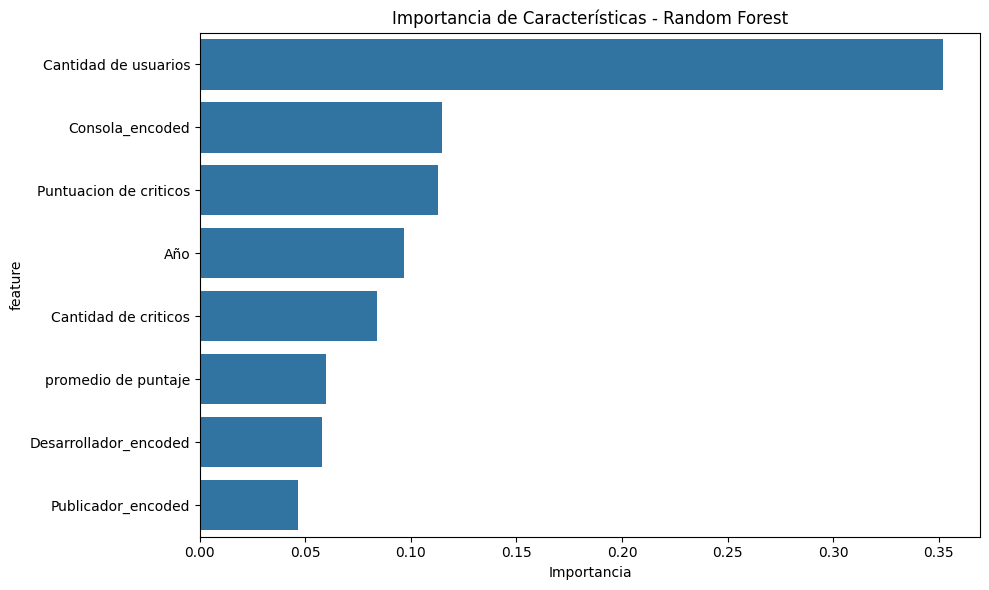

In [ ]:
# Preparar datos para feature selection
# Codificar variables categóricas
label_encoders = {}
categorical_cols = ['Genero', 'Consola', 'Publicador', 'Desarrollador', 'Clasificacion por Edad']

for col in categorical_cols:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le

# Definir características y variable objetivo
features = ['Año', 'promedio de puntaje', 'Puntuacion de criticos', 'Puntaje de Usuario',
            'Cantidad de criticos', 'Cantidad de usuarios', 'Genero_encoded', 'Consola_encoded']

# Agregar otras características codificadas si existen
if 'Publicador_encoded' in df_clean.columns:
    features.append('Publicador_encoded')
if 'Desarrollador_encoded' in df_clean.columns:
    features.append('Desarrollador_encoded')

X = df_clean[features].fillna(0)
y_regression = df_clean['Ventas Totales']

# Para clasificación: definir éxito comercial (ventas > percentil 75)
threshold = df_clean['Ventas Totales'].quantile(0.75)
y_classification = (df_clean['Ventas Totales'] > threshold).astype(int)

print(f"Umbral para éxito comercial: {threshold:.2f} millones")
print(f"Proporción de juegos exitosos: {y_classification.mean():.2%}")

# Método 1: SelectKBest con f_regression
selector_kbest = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector_kbest.fit_transform(X, y_regression)
selected_features_kbest = X.columns[selector_kbest.get_support()]

print("\n--- Método SelectKBest (Top 5 características) ---")
print("Características seleccionadas:")
for i, feature in enumerate(selected_features_kbest, 1):
    print(f"{i}. {feature}")

# Método 2: Random Forest para importancia de características
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector.fit(X, y_regression)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Importancia de Características (Random Forest) ---")
print(feature_importance.head(8))

# Seleccionar las 6 características más importantes
selected_features = feature_importance.head(6)['feature'].tolist()
print(f"\nCaracterísticas seleccionadas para el modelo: {selected_features}")

# Visualizar importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(8), x='importance', y='feature')
plt.title('Importancia de Características - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

# Algoritmo de Regresión para Predecir Ventas Totales

In [ ]:
# Usar las características seleccionadas
X_selected = X[selected_features]

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_regression, test_size=0.2, random_state=42
)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo 1: Random Forest Regressor
print("=== MODELO DE REGRESIÓN: PREDICCIÓN DE VENTAS TOTALES ===")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Modelo 2: Linear Regression (benchmark)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print("\nResultados de Regresión:")

=== MODELO DE REGRESIÓN: PREDICCIÓN DE VENTAS TOTALES ===

Resultados de Regresión:


# Cálculo de Métricas para Validar el Modelo


Random Forest:
  MSE: 1.9992
  RMSE: 1.4139
  R²: 0.2666

Linear Regression:
  MSE: 2.1238
  RMSE: 1.4573
  R²: 0.2208

Validación Cruzada (R²):
Random Forest: 0.2644 (+/- 0.2643)
Linear Regression: 0.1443 (+/- 0.1388)


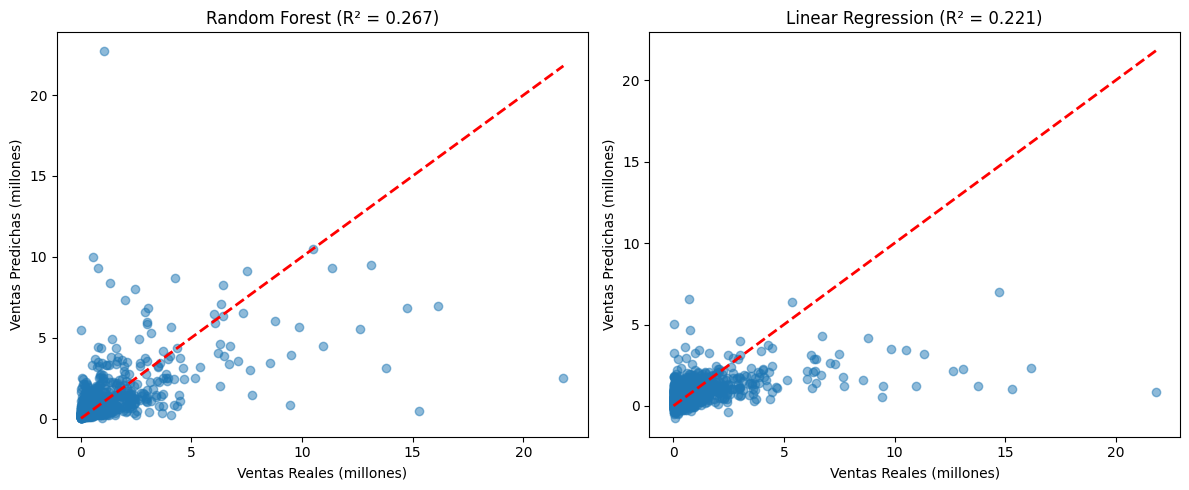

In [ ]:
# Métricas para regresión
def evaluate_regression(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")

    return rmse, r2

rmse_rf, r2_rf = evaluate_regression(y_test, y_pred_rf, "Random Forest")
rmse_lr, r2_lr = evaluate_regression(y_test, y_pred_lr, "Linear Regression")

# Validación cruzada
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"\nValidación Cruzada (R²):")
print(f"Random Forest: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")
print(f"Linear Regression: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ventas Reales (millones)')
plt.ylabel('Ventas Predichas (millones)')
plt.title(f'Random Forest (R² = {r2_rf:.3f})')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ventas Reales (millones)')
plt.ylabel('Ventas Predichas (millones)')
plt.title(f'Linear Regression (R² = {r2_lr:.3f})')

plt.tight_layout()
plt.show()

# Modelo de Clasificación: Éxito Comercial


=== MODELO DE CLASIFICACIÓN: PREDICCIÓN DE ÉXITO COMERCIAL ===

Accuracy: 0.8493

Reporte de Clasificación:
              precision    recall  f1-score   support

  No Exitoso       0.87      0.95      0.90      1033
     Exitoso       0.77      0.56      0.65       341

    accuracy                           0.85      1374
   macro avg       0.82      0.75      0.78      1374
weighted avg       0.84      0.85      0.84      1374



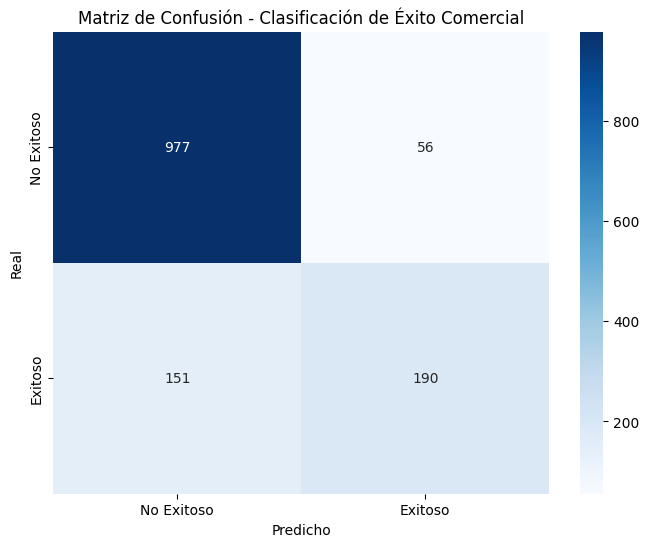

Validación Cruzada (Accuracy): 0.8309 (+/- 0.0217)


In [ ]:
print("\n=== MODELO DE CLASIFICACIÓN: PREDICCIÓN DE ÉXITO COMERCIAL ===")

# Dividir datos para clasificación
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_selected, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Escalar características
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

# Modelo de clasificación: Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_clf = rf_clf.predict(X_test_clf_scaled)
y_pred_proba = rf_clf.predict_proba(X_test_clf_scaled)[:, 1]

# Métricas de clasificación
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nReporte de Clasificación:")
print(classification_report(y_test_clf, y_pred_clf,
                          target_names=['No Exitoso', 'Exitoso']))

# Matriz de confusión
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Exitoso', 'Exitoso'],
            yticklabels=['No Exitoso', 'Exitoso'])
plt.title('Matriz de Confusión - Clasificación de Éxito Comercial')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Validación cruzada para clasificación
cv_scores_clf = cross_val_score(rf_clf, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
print(f"Validación Cruzada (Accuracy): {cv_scores_clf.mean():.4f} (+/- {cv_scores_clf.std() * 2:.4f})")

# Análisis de Resultados y Conclusiones

In [ ]:
print("\n" + "="*60)
print("ANÁLISIS DE RESULTADOS Y CONCLUSIONES")
print("="*60)

# Análisis de características importantes
feature_analysis = pd.DataFrame({
    'Característica': selected_features,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n1. ANÁLISIS DE CARACTERÍSTICAS MÁS IMPORTANTES:")
for idx, row in feature_analysis.iterrows():
    print(f"   {row['Característica']}: {row['Importancia']:.3f}")

# Interpretación de resultados
print("\n2. INTERPRETACIÓN DE RESULTADOS:")
print(f"   • El modelo de Random Forest explica aproximadamente {r2_rf:.1%} de la variabilidad en ventas")
print(f"   • El error promedio (RMSE) es de {rmse_rf:.2f} millones de unidades")
print(f"   • El modelo de clasificación tiene una precisión del {accuracy:.1%}")

print("\n3. FACTORES CLAVE IDENTIFICADOS:")
key_factors = feature_analysis.head(3)
for factor in key_factors['Característica']:
    if 'promedio' in factor:
        print("   • Puntuación promedio (críticos + usuarios) es crucial para el éxito")
    elif 'Año' in factor:
        print("   • El año de lanzamiento influye en las ventas (tendencias temporales)")
    elif 'Puntuacion' in factor:
        print("   • La puntuación de críticos tiene alto impacto en ventas")
    elif 'Cantidad' in factor:
        print("   • La cantidad de reseñas indica visibilidad y interés")

print("\n4. RECOMENDACIONES PARA DESARROLLADORES:")
print("   • Enfocarse en alta calidad para obtener buenas puntuaciones de críticos")
print("   • Considerar timing de lanzamiento basado en tendencias del mercado")
print("   • Generar suficiente atención previa al lanzamiento (cantidad de reseñas)")
print("   • La plataforma (consola) seleccionada impacta significativamente en ventas")

print("\n5. LIMITACIONES DEL MODELO:")
print("   • Datos históricos hasta 2016 (industria ha evolucionado)")
print("   • No considera marketing budget ni estrategias de precio")
print("   • No incluye factores externos como competencia o economía")
print("   • El modelo es predictivo pero no determina causalidad")

# Análisis adicional por género
print("\n6. ANÁLISIS ADICIONAL POR GÉNERO:")
genre_sales = df_clean.groupby('Genero')['Ventas Totales'].mean().sort_values(ascending=False)
print("   Ventas promedio por género (millones):")
for genre, sales in genre_sales.head(5).items():
    print(f"   • {genre}: {sales:.2f}")

# Predicción de ejemplo
print("\n7. EJEMPLO DE PREDICCIÓN:")
sample_idx = 0
sample_features = X_test_scaled[sample_idx].reshape(1, -1)
predicted_sales = rf_model.predict(sample_features)[0]
actual_sales = y_test.iloc[sample_idx]

print(f"   Predicción: {predicted_sales:.2f} millones")
print(f"   Valor real: {actual_sales:.2f} millones")
print(f"   Error: {abs(predicted_sales - actual_sales):.2f} millones")



ANÁLISIS DE RESULTADOS Y CONCLUSIONES

1. ANÁLISIS DE CARACTERÍSTICAS MÁS IMPORTANTES:
   Cantidad de usuarios: 0.364
   Puntuacion de criticos: 0.163
   Cantidad de criticos: 0.139
   Consola_encoded: 0.132
   Año: 0.119
   promedio de puntaje: 0.083

2. INTERPRETACIÓN DE RESULTADOS:
   • El modelo de Random Forest explica aproximadamente 26.7% de la variabilidad en ventas
   • El error promedio (RMSE) es de 1.41 millones de unidades
   • El modelo de clasificación tiene una precisión del 84.9%

3. FACTORES CLAVE IDENTIFICADOS:
   • La cantidad de reseñas indica visibilidad y interés
   • La puntuación de críticos tiene alto impacto en ventas
   • La cantidad de reseñas indica visibilidad y interés

4. RECOMENDACIONES PARA DESARROLLADORES:
   • Enfocarse en alta calidad para obtener buenas puntuaciones de críticos
   • Considerar timing de lanzamiento basado en tendencias del mercado
   • Generar suficiente atención previa al lanzamiento (cantidad de reseñas)
   • La plataforma (cons

# Resumen Ejecutivo del Modelo

In [ ]:
# Resumen ejecutivo
print("\n" + "="*50)
print("RESUMEN EJECUTIVO DEL MODELO PREDICTIVO")
print("="*50)

summary_data = {
    'Métrica': [
        'Características seleccionadas',
        'R² (Random Forest)',
        'RMSE (millones)',
        'Accuracy (Clasificación)',
        'Característica más importante',
        'Validación cruzada (R²)'
    ],
    'Valor': [
        len(selected_features),
        f"{r2_rf:.3f}",
        f"{rmse_rf:.3f}",
        f"{accuracy:.3f}",
        feature_analysis.iloc[0]['Característica'],
        f"{cv_scores_rf.mean():.3f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\nModelo final entrenado con {len(df_clean)} muestras")
print(f"Variables predictoras: {', '.join(selected_features)}")


RESUMEN EJECUTIVO DEL MODELO PREDICTIVO
                      Métrica                Valor
Características seleccionadas                    6
           R² (Random Forest)                0.267
              RMSE (millones)                1.414
     Accuracy (Clasificación)                0.849
Característica más importante Cantidad de usuarios
      Validación cruzada (R²)                0.264

Modelo final entrenado con 6867 muestras
Variables predictoras: Cantidad de usuarios, Consola_encoded, Puntuacion de criticos, Año, Cantidad de criticos, promedio de puntaje
